## RNN Timeseries Prediction (on a synthetic dataset)
**Author: Prathyusha Sangam**

**References:**
* Textbook: Hands-On Machine Learning with Scikit-Learn and TensorFlow
* Python / Tensor Flow documentation

### Document Outline
* [About the data](#About-the-data)
* [Project objective](#Project-objective)
* [Step 0: Set up imports](#Step-0:-Set-up-imports)
* [Step 1: Read and visualize data](#Step-1:-Read-and-visualize-data)
    * [Descriptive Statistics](#Descriptive-Statistics)
    * [Visualize x1, x2, y for timesteps t1-100](#Visualize-x1,-x2,-y-for-timesteps-t1-100)
* [Step 2: Train-test splits](#Step-2:-Train-test-splits)
* [Step 3: Construct computation graph for basic RNN](#Step-3:-Construct-computation-graph-for-basic-RNN)
* [Step 4: Generate mini batches](#Step-4:-Generate-mini-batches)
* [Step 5: Train the RNN](#Step-5:-Train-the-RNN)
* [Step 6: Test RNN for timesteps 81-100](#Step-6:-Test-RNN-for-timesteps-81-100)
* [Step 7: Plot of actual and predicted values of y versus time-step t](#Step-7:-Plot-of-actual-and-predicted-values-of-y-versus-time-step-t)

### About the data
The data used is a synthetic dataset with 100 rows and 3 columns of numbers. The column names are x(1), x(2), y. Each row contains the data for one time step. The time steps (t1, t2, · · · , t100) are equally spaced and are in increasing order as we move down the rows.

### Project objective

Goal of the project is
* To train a Reccurent Neural Network(RNN) using data of time steps t1-t99
* To make a prediction for the outputs y81, y82, · · · , y100, using the inputs x81, x82, · · · , x100, where x = (x(1), x(2)) ∈ R^2  (The number of time steps in each sequence of the RNN are to be set to 20.)

### Step 0: Set up imports

In [1]:
#Data manipulation
import numpy as np
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# allowing multiple/scrollable outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#tensor flow for NN
import tensorflow as tf

# randomseed (sourced from textbook)
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

**[Back To Top](#Document-Outline)**

### Step 1: Read and visualize data 

In [2]:
#load data
dataset = pd.read_csv("Datasets/synthetic_timeseries.csv")

# uncomment to view 1st 5 rows of data
# dataset.head()

#### Descriptive Statistics

* The data provided is a synthetic timeseries, the values of x(1) lie between -1.53 to 1.45, x(2) lie between -0.0007 to 1.3028 and y lie between -2.6283 to 1.1838.
* From the histograms we see y appears to be multimodal. we observe that the data overall is noisy.


Descriptive stats:


,x(1),x(2),y
count,100.000000,100.000000,100.000000
mean,-0.060695,0.585287,-0.581978
std,0.776056,0.352430,1.023663
min,-1.535600,-0.000700,-2.628300
25%,-0.628700,0.281950,-1.347675
50%,-0.012950,0.581350,-0.427950
75%,0.545725,0.852225,0.292650
max,1.453300,1.302800,1.183800


Histograms of the features and target:


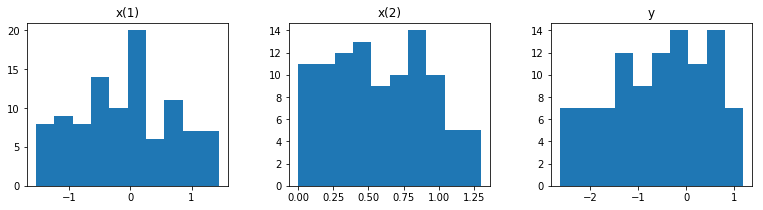

In [3]:
# understanding the data values
print("Descriptive stats:")
dataset.describe()

print("Histograms of the features and target:")
_= dataset.hist(layout = (1,3),figsize=(13,3), grid = False)

#### Visualize x1, x2, y for timesteps t1-100

* From the time-series plots of data we notice that x(1) seems to have some form of exponential growth with reccuring seasonality.
* x(2) seems to have very minute (negligible) seasonality between timesteps, but has an overall V shaped trend. There is a continuous dropping trend until timestep 50 and rise from there on.
* y seems to have an overall increasing trend upto timestep 60 and seems to be gradually dropping, we observe strong seasonality after timestep 20 which propogates through to the end.

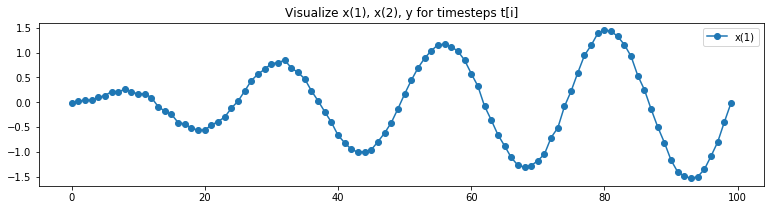

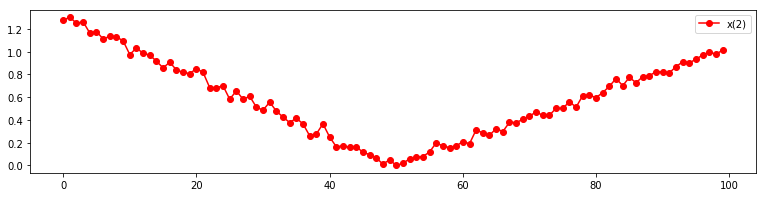

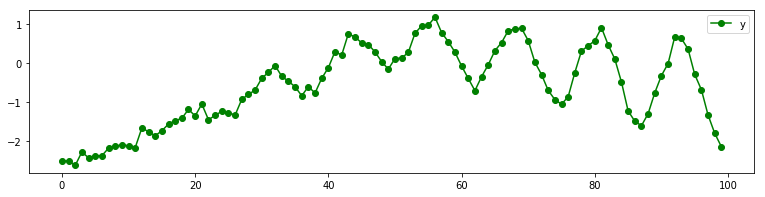

In [4]:
# visualize x(1), x(2), y for timesteps t[i]

_= dataset.plot(y='x(1)',marker = 'o', figsize=(13,3), title = 'Visualize x(1), x(2), y for timesteps t[i]')
_= dataset.plot(y='x(2)',marker='o', figsize=(13,3),color = 'red')
_= dataset.plot(use_index=True, y='y', marker='o', figsize=(13,3), color = 'green')

**[Back To Top](#Document-Outline)**

### Step 2: Train test splits

* X_train - x(1), x(2) of 1 - 99 time steps
* X_test - x(1), x(2) of time steps 81-100
* y_train - y of 1 - 99 time steps
* y_test - y of of time steps 81-100

In [5]:
X_train = dataset.iloc[0:99,0:2]
y_train = dataset.iloc[0:99,2:3]

X_test = dataset.iloc[80:100,0:2]
y_test = dataset.iloc[80:100,2:3]

#converting the dataframes to arrays

X_train = np.c_[X_train]
X_test = np.c_[X_test]
y_train = np.c_[y_train]
y_test = np.c_[y_test]


#uncomment to view the arrays
# X_train
# X_test
# y_train
# y_test

**[Back To Top](#Document-Outline)**

### Step 3: Construct computation graph for basic RNN

* Computation graph for a BasicRNNCell with 200 neurons, 20 time steps (n steps=20) is constructed.
* Learning rate is set to 0.001
* Adam Optimizer us used for the optimization process.

In [6]:
# create RNN with required specifications

reset_graph()

n_steps = 20
n_inputs = 2
n_neurons = 200
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])


# wrap the cell in an OutputProjectionWrapper

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)


# using dynamic rnn

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# setting learning rate, loss, AdamOptimizer

learning_rate = 0.001
loss = tf.reduce_mean(tf.square(outputs - y)) # calculating MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

**[Back To Top](#Document-Outline)**

### Step 4: Generate mini batches

* The first time step is generated randomly
* A sequence of 20 consecutive timesteps is produced, using the first random step as starting value
* X_train and y_train of corresponding timesteps are returned


In [7]:
# mini batches

t_min, t_max = 1, 101

def next_batch(X_train, y_train, batch_size, n_steps):
    
    t0 = (np.random.rand(batch_size, 1) * (t_max - t_min - n_steps)).astype(int) #generate random 1st step
    Ts = t0 + np.arange(0, n_steps)  #generate 20 consecutive timesteps 
#     print("t0", t0)
#     print("ts", Ts)
    return X_train[Ts], y_train[Ts]


**[Back To Top](#Document-Outline)**

### Step 5: Train the RNN

* RNN model is trained by executing the computation graph above using 5000 iterations
* For every 100th iteration,the mean squared error of the estimated y values is displayed
* The model is saved for future use

In [8]:
saver = tf.train.Saver()

n_iterations = 5000
batch_size = 25

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(X_train, y_train, batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration+100, "\tMSE:", mse)
    saver.save(sess, "./time_series_model")

100 	MSE: 0.9184851
200 	MSE: 0.047079835
300 	MSE: 0.023522697
400 	MSE: 0.010255517
500 	MSE: 0.00694199
600 	MSE: 0.004879759
700 	MSE: 0.0043611345
800 	MSE: 0.0031643177
900 	MSE: 0.0032848879
1000 	MSE: 0.0026039947
1100 	MSE: 0.002989747
1200 	MSE: 0.0028543174
1300 	MSE: 0.0024040905
1400 	MSE: 0.002683673
1500 	MSE: 0.002415355
1600 	MSE: 0.0021001643
1700 	MSE: 0.0024607119
1800 	MSE: 0.0029606994
1900 	MSE: 0.002613655
2000 	MSE: 0.0017338909
2100 	MSE: 0.002210307
2200 	MSE: 0.0021279904
2300 	MSE: 0.002555645
2400 	MSE: 0.0021719967
2500 	MSE: 0.002139188
2600 	MSE: 0.0016189163
2700 	MSE: 0.0016124161
2800 	MSE: 0.002340718
2900 	MSE: 0.002530897
3000 	MSE: 0.0015360217
3100 	MSE: 0.0016772485
3200 	MSE: 0.0023018557
3300 	MSE: 0.0016938968
3400 	MSE: 0.0015774353
3500 	MSE: 0.0018997065
3600 	MSE: 0.0021964975
3700 	MSE: 0.0016038347
3800 	MSE: 0.0012130325
3900 	MSE: 0.0016772986
4000 	MSE: 0.0015150746
4100 	MSE: 0.002039236
4200 	MSE: 0.0017949981
4300 	MSE: 0.0018318

'./time_series_model'

**[Back To Top](#Document-Outline)**

### Step 6: Test RNN for timesteps 81-100
* The test is run to predict values for y81, y82, · · · , y100 and RMSE is reported for each step (below)
* Although the RMSEs seem a bit bigger than expected (especially around timesteps 81-83), the predictions are decent.

In [9]:
#testing
with tf.Session() as sess:                       
    saver.restore(sess, "./time_series_model") 

    X_new = X_test.reshape(1, n_steps, 2)
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    

INFO:tensorflow:Restoring parameters from ./time_series_model


In [10]:
#calculating RMSE  
rmse = np.sqrt(np.square(y_pred - y_test))

# printing RMSE for timesteps 81-100
rmse = rmse.reshape(20,1)
for i in range(0,20):
    print ("Time-step", i+81,":", rmse[i])

Time-step 81 : [0.1284384]
Time-step 82 : [0.40814868]
Time-step 83 : [0.11027378]
Time-step 84 : [0.12142115]
Time-step 85 : [0.07984757]
Time-step 86 : [0.04008665]
Time-step 87 : [0.02410948]
Time-step 88 : [0.00925969]
Time-step 89 : [0.02056716]
Time-step 90 : [0.03492946]
Time-step 91 : [0.03241293]
Time-step 92 : [0.00900709]
Time-step 93 : [0.01779404]
Time-step 94 : [0.00284858]
Time-step 95 : [0.0031849]
Time-step 96 : [0.02182991]
Time-step 97 : [0.02526128]
Time-step 98 : [0.02030559]
Time-step 99 : [0.03148962]
Time-step 100 : [0.0567505]


**[Back To Top](#Document-Outline)**

### Step 7: Plot of actual and predicted values of y versus time-step t
* From the plot below, we notice the predictions of starting and ending timesteps (t100) seem to have more RMSE, compared to the time steps in the middle.
* Given that we trained a basic RNN, the results obtained are very good. It is possible to improve the performance by increasing the number of iterations or by using a MultiRNNCell.

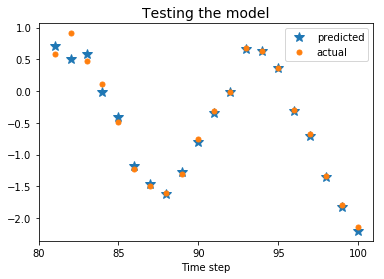

In [11]:
# #reshaping the data for plotting
y_pred = pd.DataFrame(y_pred.reshape(20,1))
y_test = pd.DataFrame(y_test.reshape(20,1))

y_pred = y_pred.set_index([[81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100]])
y_test = y_test.set_index([[81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100]])

#plotting
_= plt.title("Testing the model", fontsize=14)
_=  plt.plot(y_pred[0], "*", markersize=10, label="predicted")
_=  plt.plot(y_test[0], ".", markersize=10, label="actual")
_=  plt.legend(loc="bottom left")
_=  plt.xlabel("Time step")
_= plt.xticks([80,85,90,95,100]) 
plt.show()

**[Back To Top](#Document-Outline)**